# 04 - Regime Detection
Hidden Markov Model for market regime classification

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.features import get_hmm_features
from src.regime import MarketRegimeHMM, analyze_regimes, get_regime_durations
from src.backtest import split_data

In [2]:
feature_df = pd.read_csv('../data/nifty_features_5min.csv', parse_dates=['timestamp'])
print(f"Loaded feature data: {feature_df.shape}")

Loaded feature data: (19467, 86)


In [3]:
train_df, test_df = split_data(feature_df, train_ratio=0.7)
print(f"Training set: {len(train_df)} rows ({len(train_df)/len(feature_df)*100:.1f}%)")
print(f"Testing set: {len(test_df)} rows ({len(test_df)/len(feature_df)*100:.1f}%)")

Training set: 13626 rows (70.0%)
Testing set: 5841 rows (30.0%)


In [4]:
hmm_feature_cols = ['avg_iv', 'iv_spread', 'pcr_oi', 'call_delta', 'call_gamma', 
                    'call_vega', 'futures_basis', 'spot_returns']

train_hmm_features = train_df[hmm_feature_cols].copy()
train_hmm_features = train_hmm_features.fillna(method='ffill').fillna(0)

print("HMM Input Features:")
train_hmm_features.describe()

HMM Input Features:


,avg_iv,iv_spread,pcr_oi,call_delta,call_gamma,call_vega,futures_basis,spot_returns
count,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000
mean,0.124889,-0.009927,1.102873,0.544702,0.000926,18.461906,0.002538,0.000020
std,0.010500,0.007073,0.077647,0.023514,0.000621,7.270646,0.001705,0.001009
min,0.082000,-0.036300,0.841285,0.433301,0.000286,4.495859,-0.001302,-0.003921
25%,0.117850,-0.014700,1.048345,0.533542,0.000538,13.368677,0.001129,-0.000652
50%,0.124900,-0.010000,1.099352,0.549501,0.000679,19.469910,0.002449,0.000020
75%,0.131950,-0.005200,1.154262,0.560678,0.000996,24.107710,0.003853,0.000695
max,0.162800,0.021200,1.409876,0.601503,0.003604,34.310668,0.007477,0.003987


In [5]:
print("Training HMM model...")
hmm_model = MarketRegimeHMM(n_states=3, n_iter=100)
hmm_model.fit(train_hmm_features)
print("HMM model trained successfully!")
print(f"\nState Mapping: {hmm_model.state_mapping}")

Training HMM model...
HMM model trained successfully!

State Mapping: {0: -1, 2: 0, 1: 1}


In [6]:
all_hmm_features = feature_df[hmm_feature_cols].fillna(method='ffill').fillna(0)
feature_df['regime'] = hmm_model.predict(all_hmm_features)

print("Regime Distribution:")
print(feature_df['regime'].value_counts().sort_index())

Regime Distribution:
regime
-1    9545
 0    3820
 1    6102
Name: count, dtype: int64


In [7]:
print("\n=== Transition Matrix ===")
trans_matrix = hmm_model.get_transition_matrix()
regime_labels = ['Downtrend (-1)', 'Sideways (0)', 'Uptrend (+1)']
trans_df = pd.DataFrame(trans_matrix, index=regime_labels, columns=regime_labels)
print(trans_df.round(3))


=== Transition Matrix ===
                Downtrend (-1)  Sideways (0)  Uptrend (+1)
Downtrend (-1)           0.994         0.006         0.000
Sideways (0)             0.006         0.992         0.002
Uptrend (+1)             0.004         0.000         0.996


In [8]:
analysis = analyze_regimes(feature_df, feature_df['regime'].values)

print("\n=== Regime Analysis ===")
print("\nRegime Percentages:")
for regime, pct in analysis['percentages'].items():
    regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}[regime]
    print(f"  {regime_name}: {pct:.2f}%")

print("\nAverage Duration (candles):")
for regime, dur in analysis['avg_duration'].items():
    regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}[regime]
    print(f"  {regime_name}: {dur:.1f} candles ({dur*5:.1f} minutes)")


=== Regime Analysis ===

Regime Percentages:
  Downtrend: 49.03%
  Uptrend: 31.35%
  Sideways: 19.62%

Average Duration (candles):
  Downtrend: 238.6 candles (1193.1 minutes)
  Sideways: 318.3 candles (1591.7 minutes)
  Uptrend: 148.8 candles (744.1 minutes)


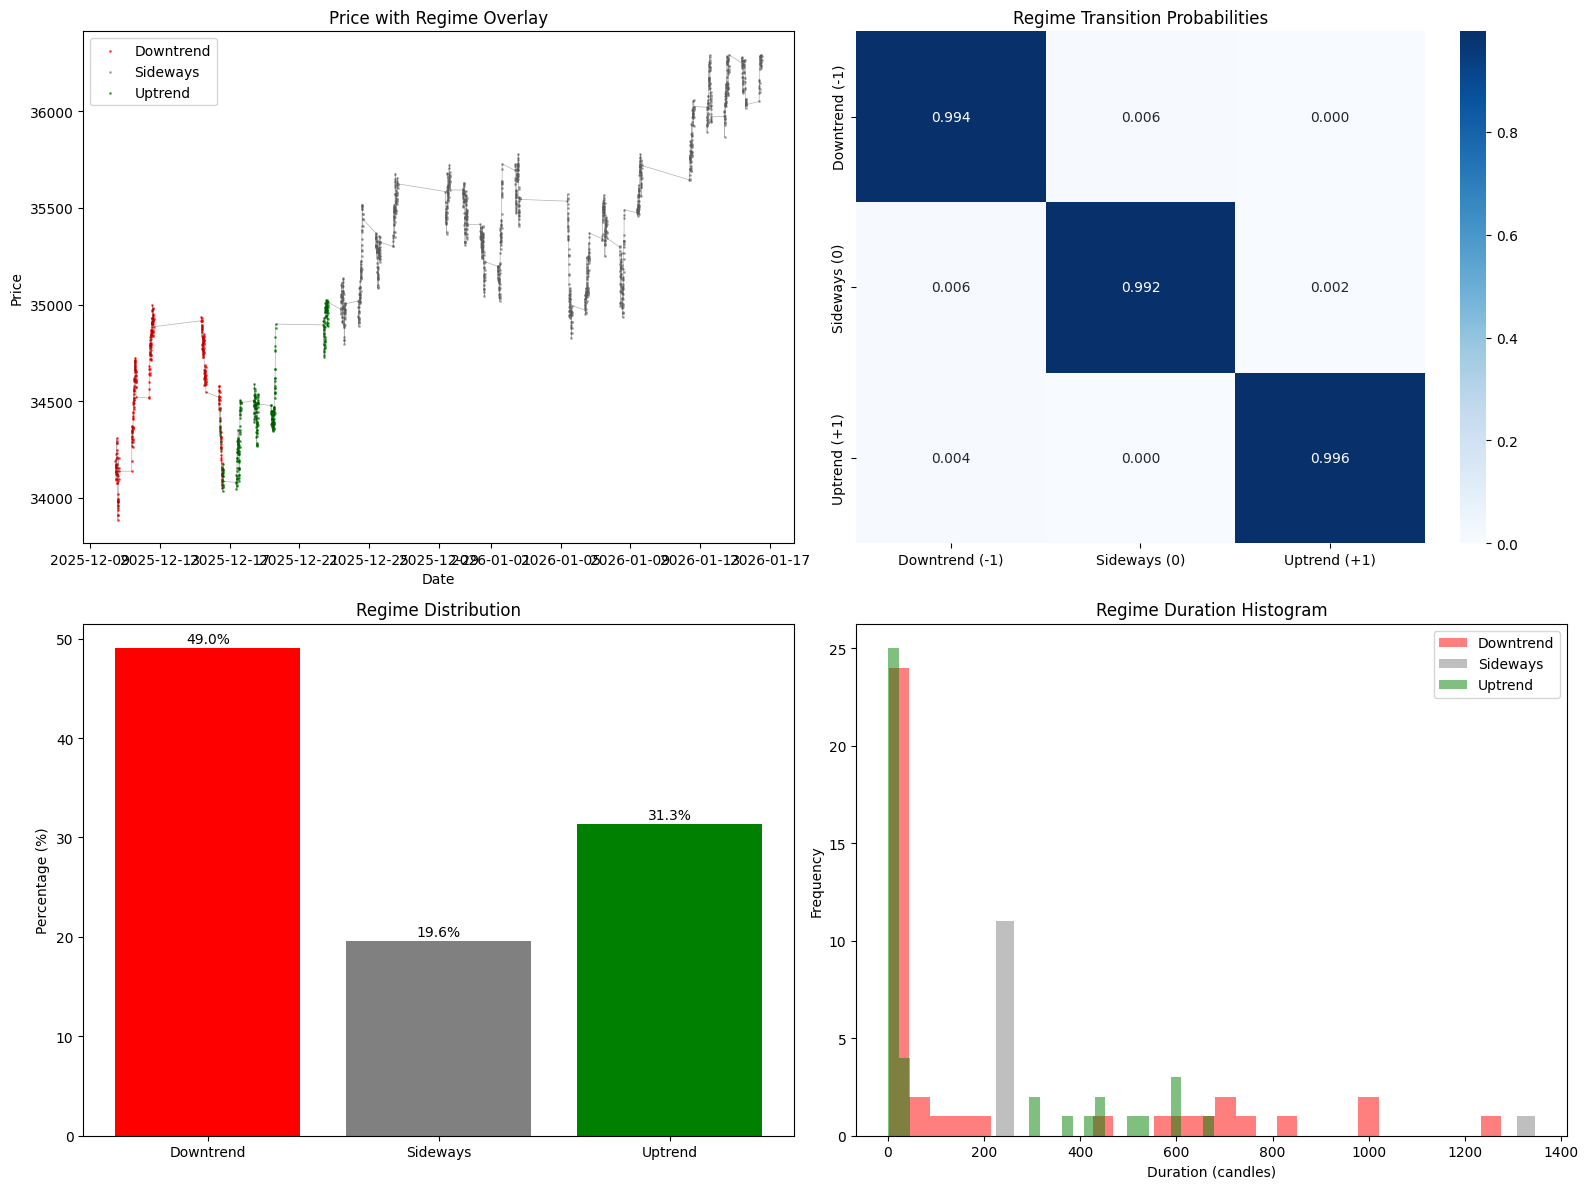

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sample = feature_df.tail(2000).copy()
colors = {-1: 'red', 0: 'gray', 1: 'green'}

ax1 = axes[0, 0]
ax1.plot(sample['timestamp'], sample['close'], 'k-', alpha=0.3, linewidth=0.5)
for regime in [-1, 0, 1]:
    mask = sample['regime'] == regime
    ax1.scatter(sample.loc[mask, 'timestamp'], sample.loc[mask, 'close'], 
               c=colors[regime], s=1, alpha=0.6, label={-1:'Downtrend', 0:'Sideways', 1:'Uptrend'}[regime])
ax1.set_title('Price with Regime Overlay')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

ax2 = axes[0, 1]
sns.heatmap(trans_df, annot=True, cmap='Blues', fmt='.3f', ax=ax2)
ax2.set_title('Regime Transition Probabilities')

ax3 = axes[1, 0]
regime_counts = [analysis['percentages'].get(r, 0) for r in [-1, 0, 1]]
bars = ax3.bar(['Downtrend', 'Sideways', 'Uptrend'], regime_counts, 
               color=['red', 'gray', 'green'])
ax3.set_title('Regime Distribution')
ax3.set_ylabel('Percentage (%)')
for bar, count in zip(bars, regime_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{count:.1f}%', ha='center')

ax4 = axes[1, 1]
durations = get_regime_durations(feature_df['regime'].values)
all_durations = []
regime_labels_list = []
for regime, dur_list in durations.items():
    all_durations.extend(dur_list)
    regime_labels_list.extend([regime] * len(dur_list))

dur_df = pd.DataFrame({'Duration': all_durations, 'Regime': regime_labels_list})
for regime in [-1, 0, 1]:
    subset = dur_df[dur_df['Regime'] == regime]['Duration']
    ax4.hist(subset, bins=30, alpha=0.5, label={-1:'Downtrend', 0:'Sideways', 1:'Uptrend'}[regime],
            color=colors[regime])
ax4.set_title('Regime Duration Histogram')
ax4.set_xlabel('Duration (candles)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.savefig('../plots/04_regime_detection.png', dpi=150)
plt.show()

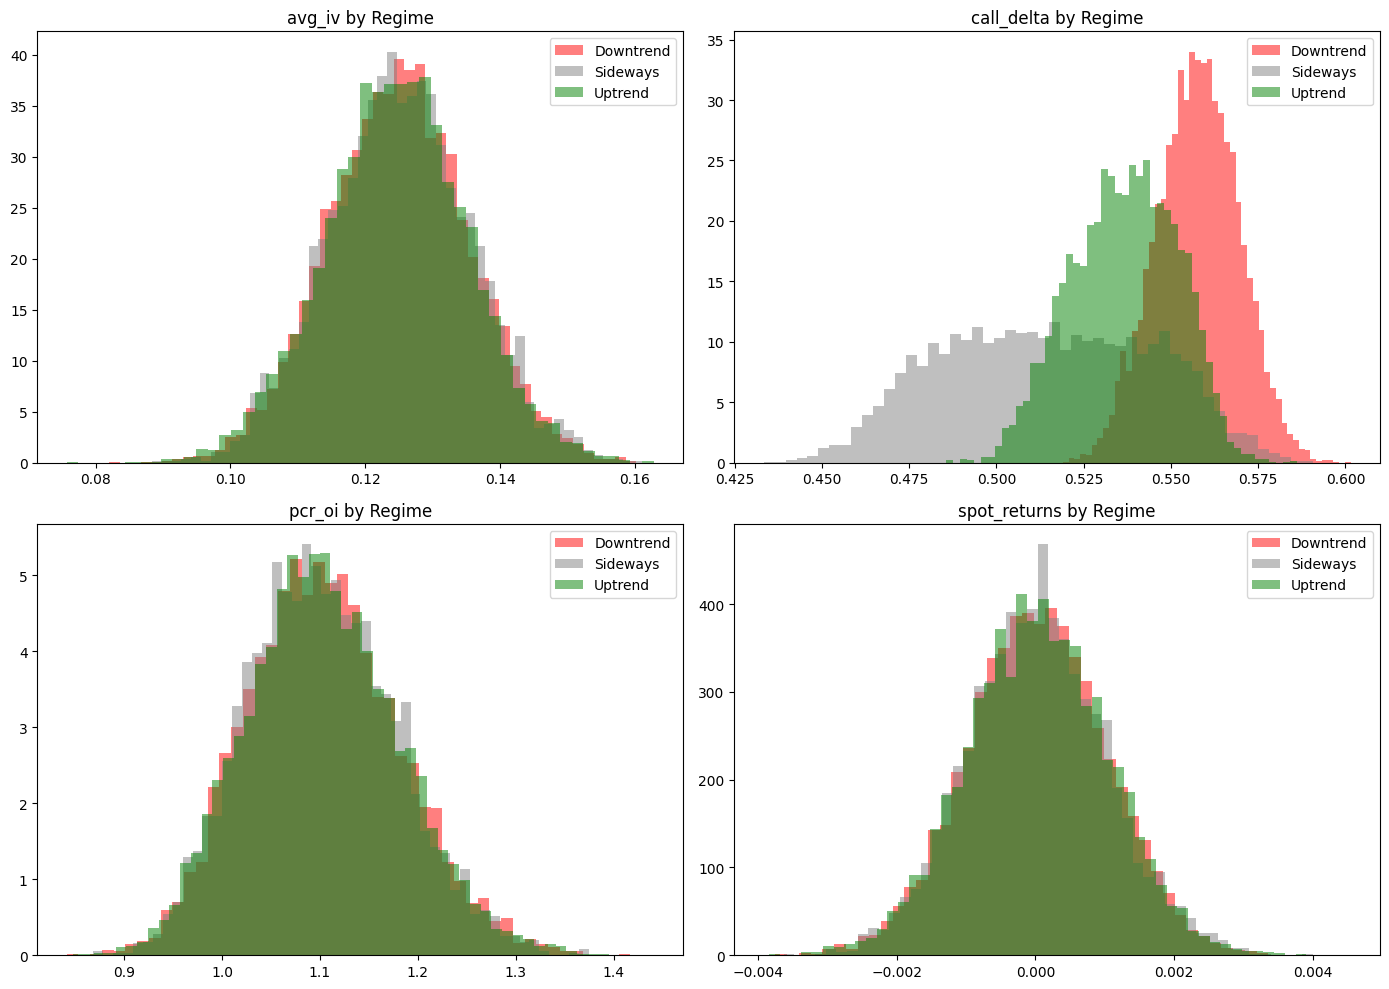

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

stats_features = ['avg_iv', 'call_delta', 'pcr_oi', 'spot_returns']

for idx, feat in enumerate(stats_features):
    ax = axes[idx // 2, idx % 2]
    for regime in [-1, 0, 1]:
        subset = feature_df[feature_df['regime'] == regime][feat]
        ax.hist(subset, bins=50, alpha=0.5, label={-1:'Downtrend', 0:'Sideways', 1:'Uptrend'}[regime],
               color=colors[regime], density=True)
    ax.set_title(f'{feat} by Regime')
    ax.legend()

plt.tight_layout()
plt.savefig('../plots/04_regime_statistics.png', dpi=150)
plt.show()

In [11]:
hmm_model.save('../models/hmm_regime_model.joblib')
feature_df.to_csv('../data/nifty_features_5min.csv', index=False)
print("\nSaved:")
print("  - models/hmm_regime_model.joblib")
print("  - data/nifty_features_5min.csv (with regime column)")


Saved:
  - models/hmm_regime_model.joblib
  - data/nifty_features_5min.csv (with regime column)
